In [33]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
import palettable
colors = palettable.colorbrewer.qualitative.Set2_7.mpl_colors

In [35]:
#!scp bullx:/scratch/sebastian.horl/explo/matsim/optimization_9jan_mode_share_opdyts.p optimization_opdyts.p
!scp hcm:/home/sebastian/work/explo/matsim/optimization_idf_ms_opdyts.p optimization_opdyts.p

optimization_idf_ms_opdyts.p                  100% 4384KB  25.7MB/s   00:00    


In [36]:
with open("optimization_opdyts.p", "rb") as f:
    data = pickle.load(f)

In [37]:
indices = [
    i for i in  np.arange(len(data["evaluations"]))
    if not data["evaluations"][i]["transitional"]
]

objectives = np.array([
    evaluation["objective"] for evaluation in data["evaluations"] if not evaluation["transitional"]
])

evaluations = np.arange(len(objectives))
    
values = np.array([
    evaluation["values"] for evaluation in data["evaluations"] if not evaluation["transitional"]
])

stuck_objectives = np.array([
    evaluation["information"]["matsim"]["objective"]["components"]["stuck"]["objective"]
    for evaluation in data["evaluations"] if not evaluation["transitional"]
])

mode_share_objectives = np.array([
    evaluation["information"]["matsim"]["objective"]["components"]["mode_share"]["objective"]
    for evaluation in data["evaluations"] if not evaluation["transitional"]
])

In [38]:
best_indices = [0]

for index in range(1, len(objectives)):
    if objectives[index] < objectives[best_indices[-1]]:
        best_indices.append(index)
    else:
        best_indices.append(best_indices[-1])
        
best_objectives = [objectives[i] for i in best_indices]

Text(0, 0.5, 'Objective')

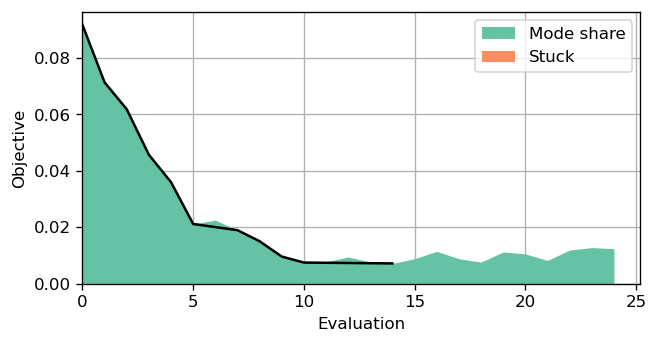

In [39]:
plt.figure(dpi = 120, figsize = (6, 3))

lower = np.zeros((len(evaluations),))

plt.fill_between(evaluations, lower, lower + mode_share_objectives, color = colors[0], 
                 label = "Mode share", zorder = 2, linewidth = 0.0)
lower += mode_share_objectives

plt.fill_between(evaluations, lower, lower + stuck_objectives, color = colors[1], 
                 label = "Stuck", zorder = 2, linewidth = 0.0)

unique_indices = np.unique(best_indices, return_index = True)[1]
plt.plot(evaluations[unique_indices], objectives[unique_indices], "k")

plt.legend(loc = "best")
plt.grid(zorder = 0)
plt.xlim([0, None])
plt.ylim([0, None])

plt.xlabel("Evaluation")
plt.ylabel("Objective")

Text(0, 0.5, 'Mode share')

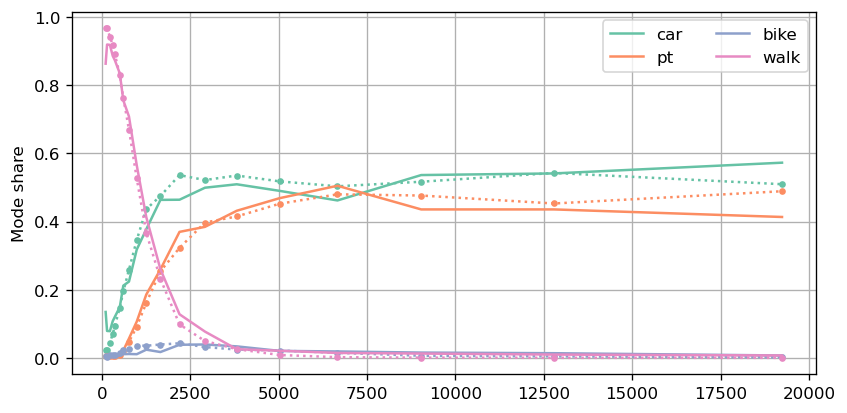

In [40]:
plt.figure(figsize = (8, 4), dpi = 120)
index = indices[best_indices[-1]]

df = data["evaluations"][index]["information"]["matsim"]["objective"]["components"]["mode_share"]["configuration"]["data"]
df

for k, mode in enumerate(df["mode"].unique()):
    df_mode = df[df["mode"] == mode]
    
    slot = "bin_index"
    slot = "upper_bound"
    
    plt.plot(df_mode[slot], df_mode["simulation_share"], color = colors[k], label = mode)
    plt.plot(df_mode[slot], df_mode["reference_share"], color = colors[k], linestyle = ":", marker = ".")
    #plt.fill_between(df_mode[slot], 
    #     df_mode["reference_share"] - 0.025, df_mode["reference_share"] + 0.025,
    #     color = colors[k], linewidth = 0.0, alpha = 0.2)
    
plt.legend(loc = "best", ncol = 2)
plt.grid()
plt.ylabel("Mode share")

In [41]:
index

193

(25, 5)

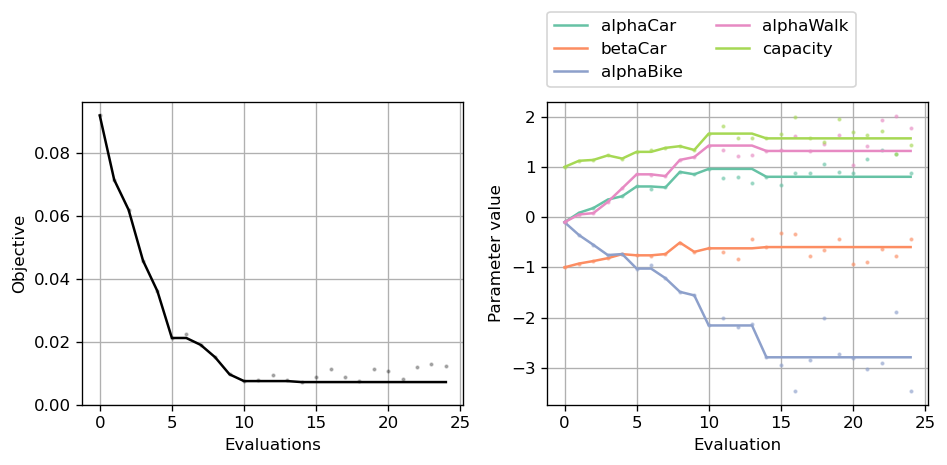

In [42]:
plt.figure(figsize = (8, 4), dpi = 120)

plt.subplot(1, 2, 1)
plt.plot(evaluations, objectives, "k.", alpha = 0.25, markersize = 3)
plt.plot(evaluations, best_objectives, "k")
plt.ylim([0, None])
plt.xlabel("Evaluations")
plt.ylabel("Objective")
plt.grid()

plt.subplot(1, 2, 2)

best_values = np.array([
    values[i] for i in best_indices
])

import palettable
colors = palettable.colorbrewer.qualitative.Set2_6.mpl_colors

labels = ["alphaCar", "betaCar", "alphaBike", "alphaWalk", "capacity"]

for k in range(values.shape[1]):
    plt.plot(values[:,k], ".", color = colors[k], alpha = 0.5, markersize = 3)
    plt.plot(best_values[:,k], color = colors[k], label = labels[k])
    
plt.grid()
plt.xlabel("Evaluation")
plt.ylabel("Parameter value")
plt.legend(loc = (0,1.05), ncol = 2)

#plt.ylim([-2.0, 2.0])

plt.tight_layout()
plt.savefig("example.png")
values.shape

In [43]:
values[best_indices[-1]]

array([ 0.80439162, -0.59564436, -2.7908048 ,  1.31909285,  1.56969402])

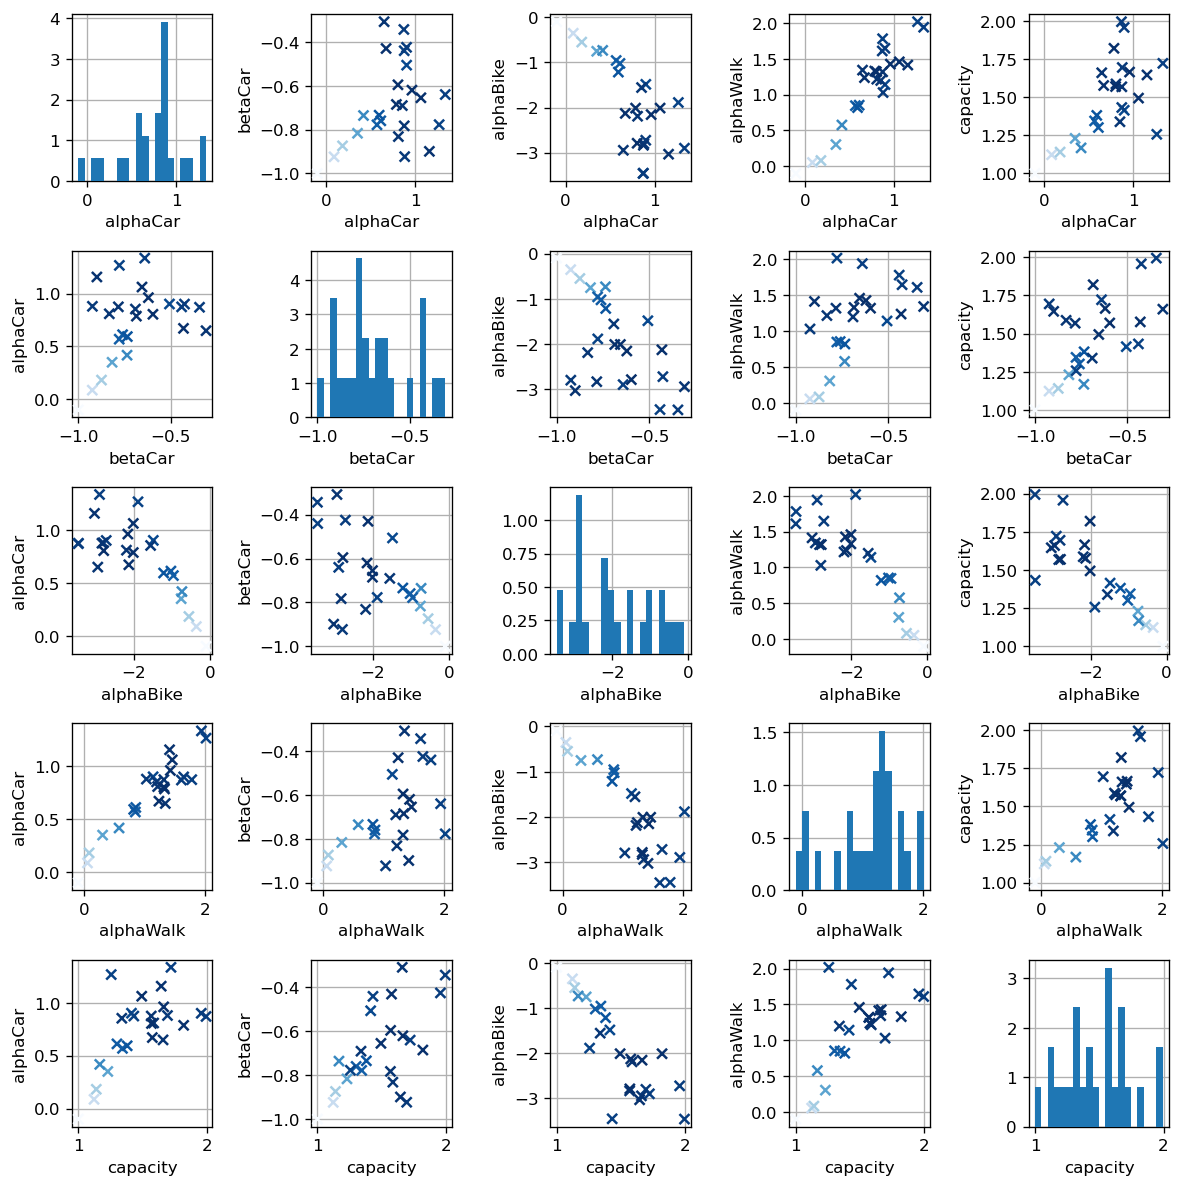

In [44]:
values = np.array([
    data["evaluations"][k]["values"]
    for k in range(len(data["evaluations"]))
    if not data["evaluations"][k]["transitional"]
])

samples, dimensions = values.shape

sorter = np.argsort(objectives)[::-1]
sorted_objectives = objectives[sorter]
sorted_values = values[sorter]

plt.figure(dpi = 120, figsize = (10, 10))
norm = plt.Normalize(np.min(objectives), np.max(objectives))

for i in range(dimensions):
    for j in range(dimensions):
        plt.subplot(dimensions, dimensions, i * dimensions + j + 1)
        
        if i == j:
            plt.hist(sorted_values[:,i], bins = 20, zorder = 5, density = True)
            
        else:
            plt.scatter(sorted_values[:,i], sorted_values[:,j], c = sorted_objectives, norm = norm, zorder = 5, cmap = "Blues_r", marker = "x")
            
        plt.grid(zorder = 0)
        
        if i == j:
            plt.xlabel(labels[i])
            
        else:
            plt.xlabel(labels[i])
            plt.ylabel(labels[j])
            
plt.tight_layout()

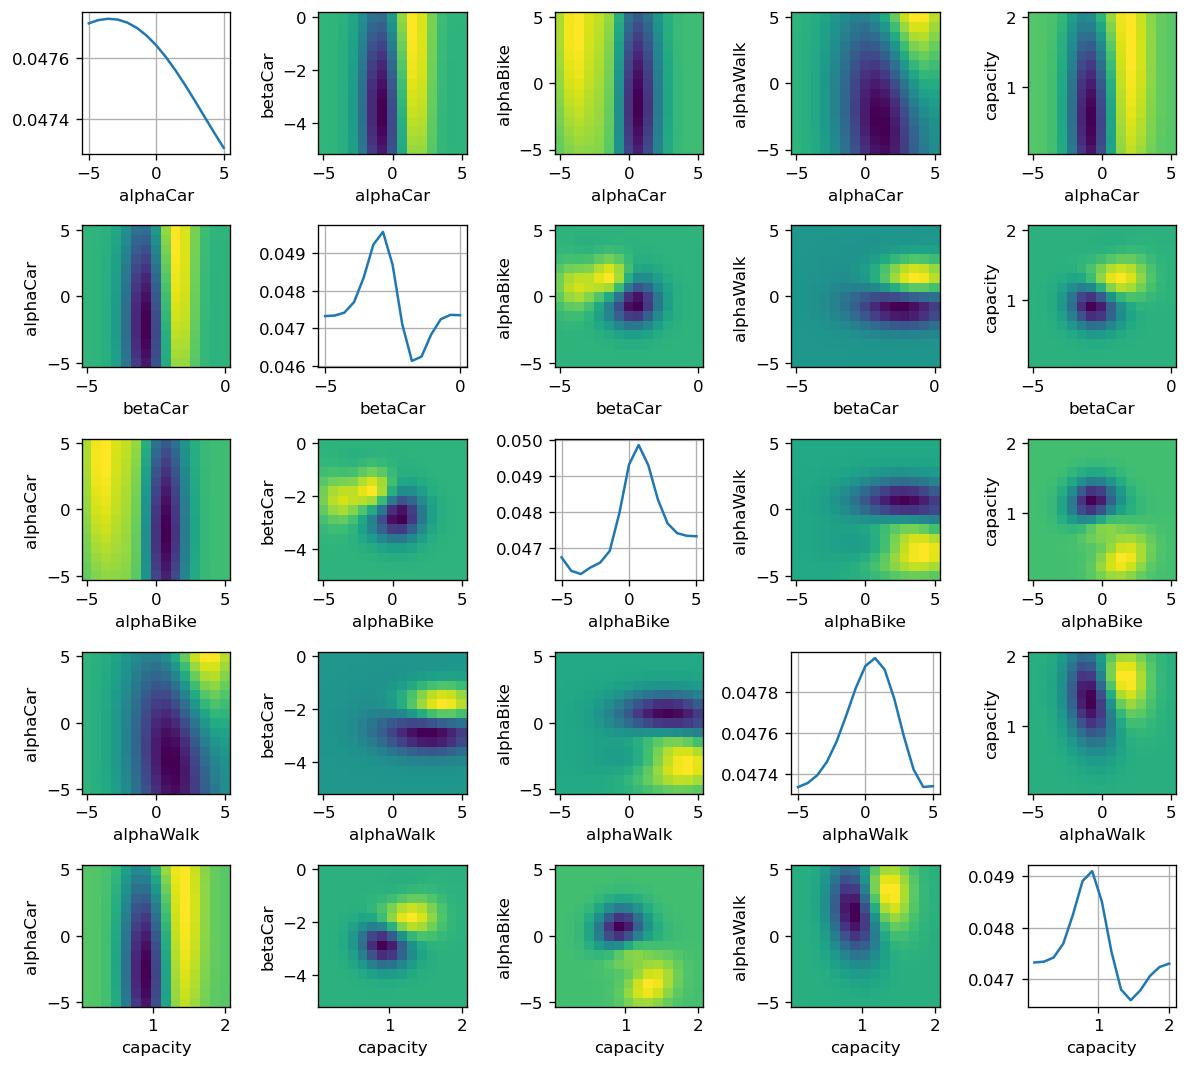

In [45]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import itertools

kernel = ConstantKernel() + RBF()
model = GaussianProcessRegressor(kernel, normalize_y = True, n_restarts_optimizer = 200)

X_samples = values
Y_samples = objectives

model.fit(X_samples, Y_samples)

gridsize = 15

X = [
    np.linspace(-5, 5, gridsize),
    np.linspace(-5, 0, gridsize),
    np.linspace(-5, 5, gridsize),
    np.linspace(-5, 5, gridsize),
    np.linspace(0.1, 2, gridsize),
]

X_prediction = list(itertools.product(*X))
Y_prediction = model.predict(X_prediction).reshape((gridsize, gridsize, gridsize, gridsize, gridsize)).T

plt.figure(dpi = 120, figsize = (10, 9))
for i in range(dimensions):
    for j in range(dimensions):
        plt.subplot(dimensions, dimensions, i * dimensions + j + 1)
        
        if i == j:
            axes = list(np.arange(5))
            axes.remove(i)

            plt.plot(X[i], np.mean(Y_prediction, axis = tuple(axes)), zorder = 5)
            
            plt.grid(zorder = 0)
            
        else:
            axes = list(np.arange(5))
            axes.remove(i)
            axes.remove(j)

            U, V = np.meshgrid(X[i], X[j])
            Z = np.mean(Y_prediction, axis = tuple(axes))

            plt.pcolor(U, V, Z, shading = "auto", cmap = "viridis_r")
            #plt.colorbar(ax = plt.gca())
        
        if i == j:
            plt.xlabel(labels[i])
            
        else:
            plt.xlabel(labels[i])
            plt.ylabel(labels[j])
            
plt.tight_layout()

In [46]:
op_types = [evaluation["information"]["type"] for evaluation in data["evaluations"]]

op_objective = np.array([
    evaluation["objective"]
    for evaluation in data["evaluations"]
])

op_candidate = np.array([
    evaluation["information"]["candidate"] if "candidate" in evaluation["information"] else -1
    for evaluation in data["evaluations"]
])

op_matsim_iterations = np.array([
    evaluation["information"]["matsim"]["iterations"]
    for evaluation in data["evaluations"]
])

op_iteration = [0]
op_transition = [0]

current_type = "initial"
current_iteration = 1

for evaluation in data["evaluations"][1:]:
    if current_type == "transition" and evaluation["information"]["type"] == "candidate":
        current_iteration += 1
    
    current_type = evaluation["information"]["type"]
    op_iteration.append(current_iteration)
    
op_iteration = np.array(op_iteration)
    
mat_iteration = np.zeros((len(op_iteration),))

for u in np.unique(op_iteration):
    mat_iteration[op_iteration > u] += np.max(op_matsim_iterations[np.where(op_iteration == u)[0]])
    
for u in np.unique(op_iteration):
    for c in np.unique(op_candidate):
        mask = (op_candidate == c) & (op_iteration == u)
        
        if np.any(mask):
            values = op_matsim_iterations[mask]
            mat_iteration[mask] += values

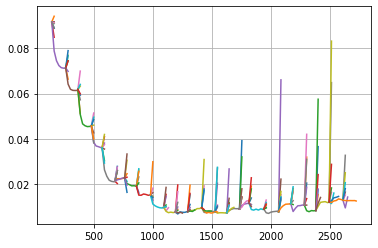

In [47]:
for u in np.unique(op_iteration):
    for c in np.unique(op_candidate):
        mask = (op_candidate == c) & (op_iteration == u)
        
        if np.any(mask) and u > 0:
            previous = np.where(op_iteration == u - 1)[0][-1]
            
            x = np.insert(mat_iteration[mask], 0, mat_iteration[previous])
            y = np.insert(op_objective[mask], 0, op_objective[previous])
            
            plt.plot(x, y)
            
plt.grid()
#plt.ylim([0, 0.1])